# О данном ноуте

В данном ноутбуке попробуем реализовать style-transfer на основе сверточных моделей

![title](https://i.ytimg.com/vi/R39tWYYKNcI/maxresdefault.jpg)

Ссылочка на оригинальную статью:

[L. Gatys, A. Ecker and M. Bethge, "Image style transfer using convolutional neural networks", Proc. IEEE Conf. Comput. Vis. Pattern Recognit. (CVPR), pp. 2414-2423, Jun. 2016.](http://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html).

Если формулировать основную идею, то у нас есть:

**Представление содержимого**: извлеченные активации из более глубоких слоев отображают структуру и объекты.

**Представление стиля**: корреляции объектов (матрицы Gram) в нескольких слоях отображают текстуры, цвета, мазки кисти.

Мы определяем функцию потерь:
* Потеря содержимого = разница между характеристиками содержимого сгенерированного изображения и исходного содержимого изображения.
* Потеря стиля = разница между матрицами Gram сгенерированного изображения и изображения в стиле.

Мы начинаем с копии изображения содержимого (или шумов) и итеративно обновляем его (градиентный спуск), чтобы минимизировать потерю стиля и содержимого.

В результате получается изображение, которое сохраняет содержимое, но имеет стиль другого изображения.

![title](https://camo.githubusercontent.com/f76a7430390ad4785b45b370860c50dd7c09341c29ea85ecab893da2fab4a52f/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313239342f312a5a6757353230535a7231516b476f4664337871594d772e6a706567)

# Часть 0 - готовим данные

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

imsize = 512 if torch.cuda.is_available() else 256

# Забегая вперед скажу что будем пользоваться VGG-19
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

unloader = transforms.ToPILImage()

def denormalize(tensor):
    tensor = tensor.clone().detach()
    mean_tensor = torch.tensor(mean).to(tensor.device)
    std_tensor = torch.tensor(std).to(tensor.device)
    if tensor.ndim == 4:  # Batched
        mean_expanded = mean_tensor.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        std_expanded = std_tensor.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    elif tensor.ndim == 3:  # Unbatched
        mean_expanded = mean_tensor.unsqueeze(1).unsqueeze(2)
        std_expanded = std_tensor.unsqueeze(1).unsqueeze(2)
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")
    denormalized = tensor * std_expanded + mean_expanded
    return torch.clamp(denormalized, 0.0, 1.0)

def show_tensor_image(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = denormalize(image)
    image = unloader(image)
    plt.figure(figsize=(6, 6))
    if title: plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [3]:
content_uploader = widgets.FileUpload(accept='image/*', multiple=False)
style_uploader = widgets.FileUpload(accept='image/*', multiple=False)

display(widgets.VBox([widgets.Label("Upload Content Image:"), content_uploader,
                      widgets.Label("Upload Style Image:"), style_uploader]))

In [4]:
import io

def load_uploaded_image(uploader):
    if len(uploader.value) == 0:
        raise ValueError("No file uploaded yet.")

    file_info = next(iter(uploader.value.values()))
    image_data = file_info['content']

    image = Image.open(io.BytesIO(image_data)).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

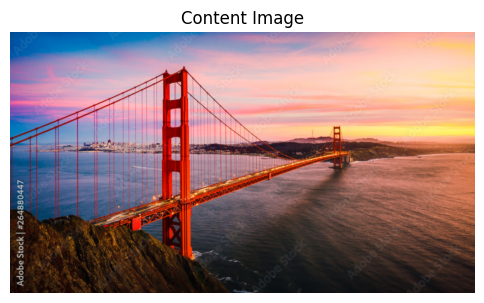

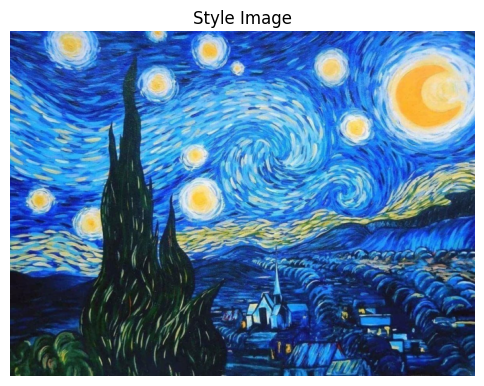

In [5]:
content_img = load_uploaded_image(content_uploader)
style_img = load_uploaded_image(style_uploader)

show_tensor_image(content_img, title="Content Image")
show_tensor_image(style_img, title="Style Image")

# Часть 1 - Моделька

Воспользуемся pre-trained VGG-19

In [6]:
import torchvision.models as models

cnn = models.vgg19(pretrained=True).features.eval().to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 78.7MB/s]


In [7]:
#for i, layer in enumerate(cnn):
    #print(i, layer)


content_layer_indices = [22,29]
style_layer_indices = [1, 6, 11, 20, 29]

Более подробно про матрицы Грамма и наши функции потерь можно почитать тут: https://wandb.ai/johnowhitaker/style_loss_showdown/reports/An-Explanation-of-Style-Transfer-With-a-Showdown-of-Different-Techniques--VmlldzozMDIzNjg0

In [8]:
def gram_matrix(features):
    b, c, h, w = features.size()
    f = features.view(c, h * w)
    gram = torch.mm(f, f.t())
    return gram.div(c * h * w)


def extract_content_features(img, cnn, content_layers):
    features = []
    x = img
    for i, layer in enumerate(cnn):
        x = layer(x)
        if i in content_layers:
            features.append(x)
    return features

def extract_style_grams(img, cnn, style_layers):
    grams = []
    x = img
    for i, layer in enumerate(cnn):
        x = layer(x)
        if i in style_layers:
            grams.append(gram_matrix(x))
    return grams

style_grams = extract_style_grams(style_img, cnn, style_layer_indices)
content_features = extract_content_features(content_img, cnn, content_layer_indices)


In [24]:
if content_img is not None:  # Just to make sure bro loaded images
# The first option will have less bias towards content which might bring some divergence to the output picture which is good sometimes
    #input_img = torch.randn_like(content_img).to(device).requires_grad_(True)
    input_img = content_img.clone().to(device).requires_grad_(True)


# Часть 2 - Обучение

In [25]:
import torch.optim as optim

# Вообще в разных имплементациях часто используют LBFGS, но для эксперимента и большего контроля я взял Adam
optimizer = optim.Adam([input_img], lr=0.3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

#optimizer = optim.LBFGS([input_img])

In [26]:
num_steps = 1000
alpha = 1.0   # Content loss weight (higher = more content preservation)
beta = 1e5   # Style loss weight (higher = more style)
losses = []

In [27]:
def compute_loss(input_img):
    x = input_img
    input_features = []
    for i, layer in enumerate(cnn):
        x = layer(x)
        input_features.append(x)

    c_loss = 0.0
    for i, idx in enumerate(content_layer_indices):
        input_content = input_features[idx]
        target_content = content_features[i].detach()
        c_loss += torch.nn.functional.mse_loss(input_content, target_content)
    c_loss /= len(content_layer_indices)

    s_loss = 0.0
    for i, style_i in enumerate(style_layer_indices):
        input_style_feat = input_features[style_i]
        input_gram = gram_matrix(input_style_feat)
        target_gram = style_grams[i].detach()
        s_loss += torch.nn.functional.mse_loss(input_gram, target_gram)

    # For more smooth loss if needed
    #if style_layer_indices:
        #s_loss /= len(style_layer_indices)

    total_loss = alpha * c_loss + beta * s_loss
    return total_loss

Step 100/1000, Total Loss: 1.5975


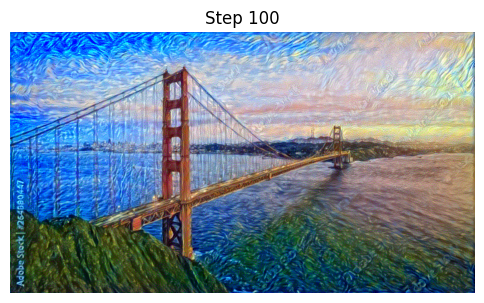

Step 200/1000, Total Loss: 1.4028


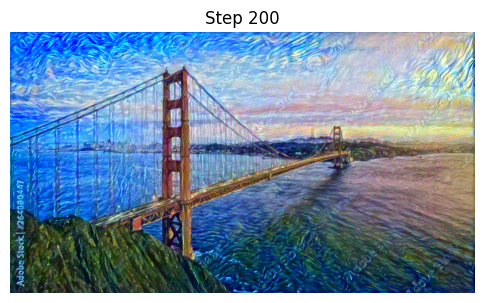

Step 300/1000, Total Loss: 1.3365


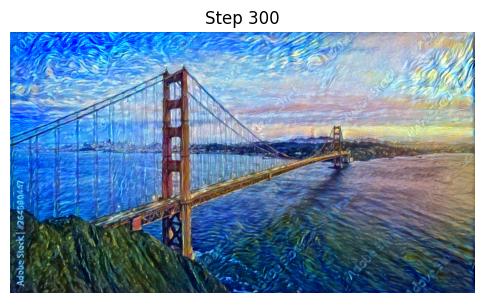

Step 400/1000, Total Loss: 1.2424


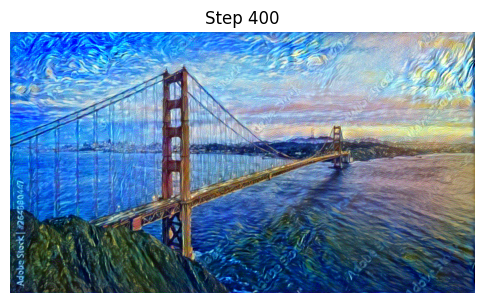

Step 500/1000, Total Loss: 1.1643


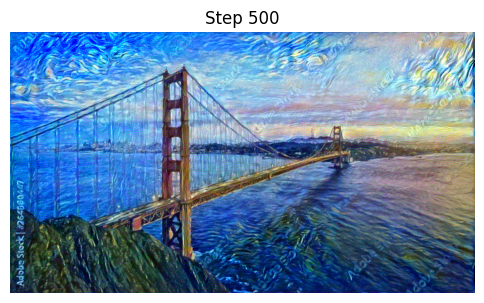

Step 600/1000, Total Loss: 1.0913


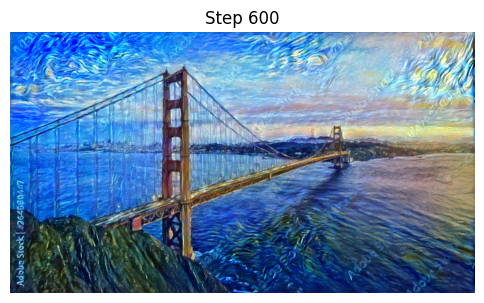

Step 700/1000, Total Loss: 1.0464


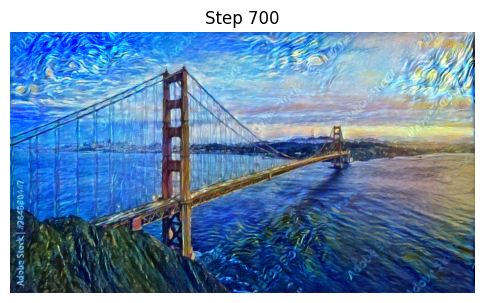

Step 800/1000, Total Loss: 1.0439


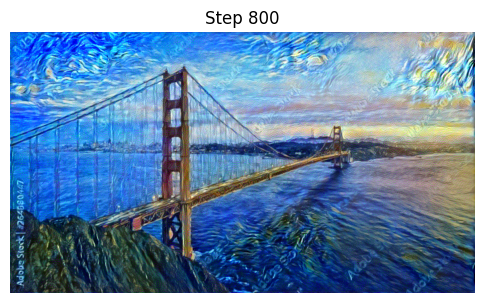

Step 900/1000, Total Loss: 1.0099


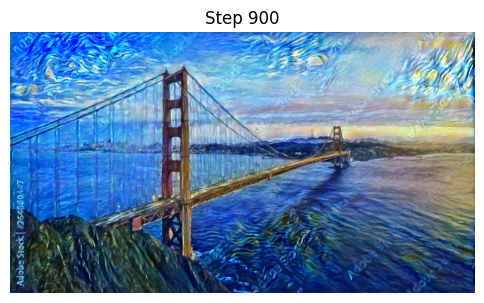

Step 1000/1000, Total Loss: 0.9917


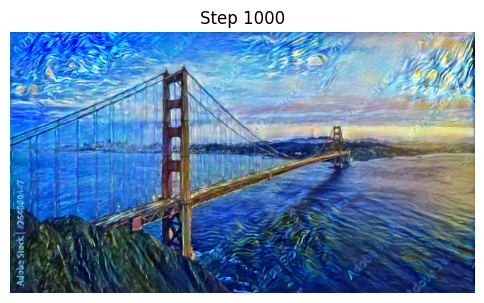

In [28]:
for step in range(num_steps):
    def closure():
        optimizer.zero_grad()
        cnn(input_img)
        loss = compute_loss(input_img)
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    scheduler.step()

    if (step + 1) % 100 == 0:
        print(f"Step {step + 1}/{num_steps}, Total Loss: {loss.item():.4f}")
        show_tensor_image(input_img, title=f"Step {step + 1}")


Ну как видим получиолсь очень симпатично, так что в данном ноуте смогли успешно реализовать Style Transfer на основе глубоких сверточных сетей